In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def discretize(Z, Zdim, Zmin, Zstep):
    ###
    #Discretize a variable Z using its dimension Zdim, its minimal values along each axis and the discretization steps
    res = [0]*Zdim #n-dimensional index
    for i in range(Zdim): #For each dimension
        elt = Z[i] #Extract the i-th element
        ind = int((elt - Zmin[i])//Zstep[i]) #Discretize
        res[i] = ind
    return(tuple(res)) #Return as tuple for array indexing

In [3]:
class Pendulum():
    def __init__(self):
        self.l = 0.6
        self.m = 1
        self.max_torque = 10
        self.max_speed = 5
        self.state = np.array([0,0])
        self.last_input = None
        self.g = 9.81
        self.dt = 0.1
        self.angle_std = 3*2*np.pi/360
        self.speed_std = 0.1
        
    def random_init(self):
        ###
        #Random initialization
        self.state = np.array([np.random.uniform(-np.pi, np.pi),np.random.uniform(-sefl.max_speed, self.max_speed)])
        
    def step(self, u):
        #Simulation step
        u = np.clip(u, -self.max_torque, self.max_torque) #Clip the input as safety
        self.last_input = u
        accel = u/(self.m*self.l*self.l) + self.g*np.sin(self.state[0])/self.l #Dynamics for the acceleration
        
        speed = self.state[1]
        angle = self.state[0]
        
        new_speed = speed + accel*self.dt + np.random.normal(0,self.speed_std) #Calculate the new speed
        new_speed = np.clip(new_speed, -self.max_speed, self.max_speed) #Clip the speed as safety (in practice the bounds were chosen to ensure this very rarely happens)
        
        new_angle = angle + speed*self.dt + np.random.normal(0,self.angle_std) #New angle
        if new_angle < -np.pi: #Angle is modulo 2\pi
            new_angle = new_angle + 2*np.pi
        if new_angle > np.pi:
            new_angle = new_angle - 2*np.pi
        
        self.state = np.array([new_angle, new_speed])
        
    def set_state(self, angle, speed):
        ###
        #Explicitely set the state
        speed = np.clip(speed, -self.max_speed, self.max_speed)
        if angle < -np.pi:
            angle = angle + 2*np.pi
        if angle > np.pi:
            angle = angle - 2*np.pi
        self.state = np.array([angle, speed])


In [4]:
#Get the plant for later use
plant_actual = np.load('plant_l06_m1.npy')

In [5]:
def cost(state):
    ###
    #Cost function
    return(state[0]*state[0] + state[1]*state[1]*0.1)

In [6]:
#Structure of the vector: angle (-pi to pi) first then speed (-5 to 5)

stateVect = np.zeros((2500,2))
for i in range(50):
    ###
    #Enumerate the states from 1 to 2500. Here we explicitly build the enumeration to later build the Q matrix and for convenience
    for j in range(50):
        angle = -np.pi + (i+0.5)*(2*np.pi/50)
        speed = -5 + (j+0.5)*0.2
        ind = i*50 + j
        stateVect[ind] = [angle, speed] #Simply store the state at its assigned index

In [7]:
diagMinusQ = np.zeros((2500,2500))
#Q matrix
for i in range(2500):
    #Build the diagonal matrix with the exponential of the opposite of the cost
    diagMinusQ[i,i] = np.exp(-cost(stateVect[i]))

In [8]:
def unravelPF(pf):
    ###
    #Utilitarian function to turn a 2D pf into a 1D, enumerated pf following the same idea as stateVect
    res = np.zeros(2500)
    for i in range(50):
        for j in range(50):
            res[i*50+j] = pf[i][j]
    return(res)

In [9]:
def powerMethod(mat, dim):
    ###
    #Power method to find for eigenvector determination
    vect = np.ones(dim) #Initial guess
    nrm = np.linalg.norm(vect) #Get the norm (we won't use this one but is is generally useful for building a stopping condition)
    for _ in range(50): #Perform 50 iterations (our heuristic stopping conditions. Resulting norms converging (before normalization!) should be used if such a heuristic can't be found)
        vect = mat.dot(vect) #Multiply the matrix and the vector
        nrm = np.linalg.norm(vect) #Normalize the result
        vect = vect/nrm
    return(vect)

In [10]:
Prob = np.zeros((2500, 2500)) #Initialize the probability matrix P
u = discretize([0], 1, [-2.5], [0.25]) #Get the index corresponding to a zero input

for i in range(50):
    for j in range(50):
        pf = plant_actual[i,j,u][0] #Get the pf
        ind1 = i*50 + j
        Prob[ind1] = unravelPF(pf) #Unravel and store it  

In [11]:
z = powerMethod(diagMinusQ@Prob, 2500) #Get the z values by solving the eigenvector problem for the matrix QP

In [12]:
def loop(x):
    ###
    #Control loop
    ind = discretize(x,  2, [-np.pi, -5], [2*np.pi/50, 0.2]) #Discretize the state
    pf = plant_actual[ind[0],ind[1],u][0] #Get the pf corresponding to the passive dynamics
    pf_1D = unravelPF(pf) #Unravel it
    pf_weighted = pf_1D*z #Calculate the actual transition pf using z and the passive dynamics
    S = np.sum(pf_weighted) #Normalize
    pf_weighted = pf_weighted/S
    ind = np.random.choice(range(2500), p=pf_weighted) #Get the new (enumerated) state index using the calculated dynamics
    newState = stateVect[ind] #Get the new state from the state vector
    return(newState)

In [13]:
fullH = np.zeros((50,300))
nSteps = 300

for j in range(50): #Perform 50 simulations
    hist = [[0,0]]*nSteps
    
    state = [np.pi, 0] #Initialize the pendulum
    for i in range(nSteps): #For each step
        hist[i]=state #Log the state
        state = loop(state) #Sample the new state
    fullH[j] = [x[0] for x in hist]

In [14]:
means = [0]*300 #Get the means and stds for plotting
stds = [0]*300
for i in range(300):
    means[i] = np.mean(fullH[:,i])
    stds[i] = np.std(fullH[:,i])

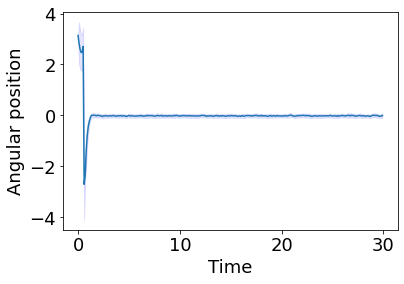

In [15]:
from matplotlib import pyplot as plt
from pylab import rcParams
plt.rcParams.update({'font.size': 18})

x = np.array([x/10 for x in range(300)])
y = np.array(means)
ci = np.array(stds)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

ax.set_xlabel('Time')
ax.set_ylabel('Angular position')
plt.savefig('klc_angle_ci.png', bbox_inches = 'tight')